In [1]:
%reset -f
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import plotly
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas_profiling import ProfileReport
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
engine = create_engine("sqlite:////Users/nathanieldirenzo/Documents/GitHub/NBM_EDA_Student/resources/get_mta/mta_data.db")

In [3]:
df = pd.read_sql('SELECT * FROM mta_data LIMIT 1000000;', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [4]:
#profile = ProfileReport(df)
#profile

In [5]:
df = df.rename(columns={'C/A': 'control_area', 'UNIT': 'unit', 'SCP': 'subunit_channel_pos', 'STATION':'station', 'LINENAME':'subway_lines', 'DIVISION':'division', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 'ENTRIES':'entries', 'EXITS':'exits'})

In [6]:
df.head()

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [7]:
df.station = df.station.str.replace("/","_")
df.station = df.station.str.replace("-","_")
df.station = df.station.str.replace(" ","_")
df.station = df.station.str.lower()

In [8]:
df['date'] = df['date'].str.replace('/','_')
df['time'] = df['time'].str.replace(':','_')
df['desc'] = df['desc'].str.replace(' ', '_')
df['subunit_channel_pos'] = df['subunit_channel_pos'].str.replace('-', '_')

In [9]:
df['unique_id'] = df['control_area'] + '_' + df['unit'] + '_' + df['subunit_channel_pos'] + '_' + df['station'] + '_' + df['date'] + '_' + df['time'] + '_' + df['desc']

In [10]:
df['date_time'] = df.date + ' ' + df.time

In [11]:
df.date_time = pd.to_datetime(df['date_time'], format = '%m_%d_%Y %H_%M_%S')

In [12]:
df = df[df.desc != 'RECOVR_AUD']

In [13]:
df['net_entries'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['entries'].transform(lambda x: x.diff())
df['net_exits'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['exits'].transform(lambda x: x.diff())
df['net_traffic'] = df.net_entries + df.net_exits

In [14]:
df['net_entries'] = abs(df.net_entries)
df['net_exits'] = abs(df.net_exits)
df['net_traffic'] = abs(df.net_traffic)

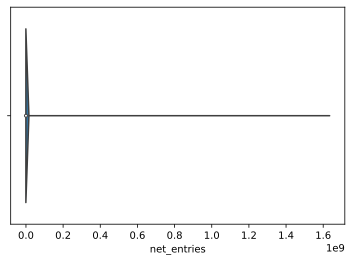

In [15]:
sns.violinplot(x=df.net_entries);

In [16]:
df.fillna(0)

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,unique_id,date_time,net_entries,net_exits,net_traffic
0,A002,R051,02_00_00,59_st,NQR456W,BMT,12_18_2021,03_00_00,REGULAR,7672966,2645023,A002_R051_02_00_00_59_st_12_18_2021_03_00_00_R...,2021-12-18 03:00:00,0.0,0.0,0.0
1,A002,R051,02_00_00,59_st,NQR456W,BMT,12_18_2021,07_00_00,REGULAR,7672969,2645040,A002_R051_02_00_00_59_st_12_18_2021_07_00_00_R...,2021-12-18 07:00:00,3.0,17.0,20.0
2,A002,R051,02_00_00,59_st,NQR456W,BMT,12_18_2021,11_00_00,REGULAR,7672991,2645127,A002_R051_02_00_00_59_st_12_18_2021_11_00_00_R...,2021-12-18 11:00:00,22.0,87.0,109.0
3,A002,R051,02_00_00,59_st,NQR456W,BMT,12_18_2021,15_00_00,REGULAR,7673037,2645193,A002_R051_02_00_00_59_st_12_18_2021_15_00_00_R...,2021-12-18 15:00:00,46.0,66.0,112.0
4,A002,R051,02_00_00,59_st,NQR456W,BMT,12_18_2021,19_00_00,REGULAR,7673097,2645270,A002_R051_02_00_00_59_st_12_18_2021_19_00_00_R...,2021-12-18 19:00:00,60.0,77.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,R228,R143,00_00_03,28_st,6,IRT,11_26_2021,20_00_00,REGULAR,2944118,2386571,R228_R143_00_00_03_28_st_11_26_2021_20_00_00_R...,2021-11-26 20:00:00,59.0,52.0,111.0
999996,R228,R143,00_00_04,28_st,6,IRT,11_20_2021,00_00_00,REGULAR,465998,409652,R228_R143_00_00_04_28_st_11_20_2021_00_00_00_R...,2021-11-20 00:00:00,4186.0,6175.0,10361.0
999997,R228,R143,00_00_04,28_st,6,IRT,11_20_2021,04_00_00,REGULAR,466006,409667,R228_R143_00_00_04_28_st_11_20_2021_04_00_00_R...,2021-11-20 04:00:00,8.0,15.0,23.0
999998,R228,R143,00_00_04,28_st,6,IRT,11_20_2021,08_00_00,REGULAR,466012,409681,R228_R143_00_00_04_28_st_11_20_2021_08_00_00_R...,2021-11-20 08:00:00,6.0,14.0,20.0


In [17]:
q = np.nanquantile(df["net_entries"], .99)
df = df[df["net_entries"] < q]

q2 = np.nanquantile(df["net_exits"], .99)
df = df[df["net_exits"] < q2]

q3 = np.nanquantile(df['net_traffic'], .99)
df=df[df['net_traffic'] < q3]

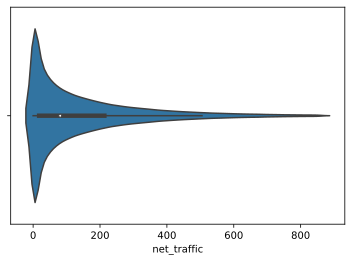

In [18]:
sns.violinplot(data=df, x='net_traffic');

In [19]:
df['day_of_week'] = df.date_time.dt.dayofweek

In [20]:
df['month'] = df.date_time.dt.month

In [21]:
df['week'] = df.date_time.dt.isocalendar().week

In [22]:
df['hour'] = df.date_time.dt.hour

In [23]:
hourly_df = df.groupby(['hour'])[['net_traffic']].mean().reset_index()

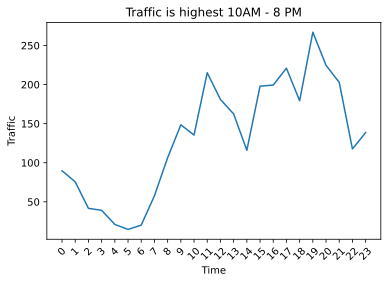

In [24]:
plt.plot(hourly_df.hour, hourly_df.net_traffic);
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.title('Traffic is highest 10AM - 8 PM')
plt.xticks(np.arange(24), rotation=45);

In [25]:
daily_timelapse_df = df.groupby(pd.Grouper(key='date_time', freq='D'))[['net_traffic']].mean().reset_index()
daily_timelapse_df['pct_change'] = daily_timelapse_df.net_traffic.pct_change()
daily_timelapse_df

,date_time,net_traffic,pct_change
0,2021-11-20,129.320637,NaN
1,2021-11-21,101.470751,-0.215355
2,2021-11-22,160.949150,0.586163
3,2021-11-23,167.363905,0.039856
4,2021-11-24,162.111297,-0.031384
...,...,...,...
30,2021-12-20,148.323426,0.553931
31,2021-12-21,150.057236,0.011689
32,2021-12-22,147.569422,-0.016579
33,2021-12-23,140.219893,-0.049804


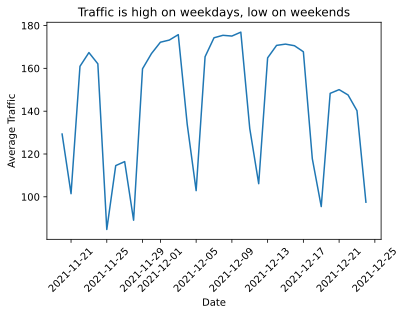

In [26]:
sns.lineplot(data=daily_timelapse_df, x='date_time', y='net_traffic');
plt.title('Traffic is high on weekdays, low on weekends')
plt.xlabel('Date')
plt.ylabel('Average Traffic')
plt.xticks(rotation=45);

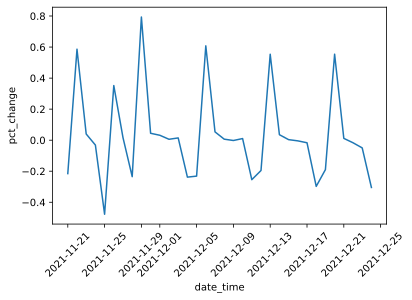

In [27]:
sns.lineplot(data=daily_timelapse_df, x='date_time', y='pct_change');
plt.xticks(rotation=45);

In [28]:
dayofweek_df = df.groupby(df.day_of_week)[['net_traffic']].sum()
dayofweek_df['pct_change'] = dayofweek_df.net_traffic.pct_change()
dayofweek_df['pct_change'].iloc[0] = ((dayofweek_df.net_traffic.iloc[0] - dayofweek_df.net_traffic.iloc[6]) / dayofweek_df.net_traffic.iloc[6])
dayofweek_df['pct_total'] = dayofweek_df['net_traffic'].apply(lambda x: x / dayofweek_df.net_traffic.sum())
dayofweek_df

,net_traffic,pct_change,pct_total
day_of_week,,,
0,22313540.0,0.595652,0.159652
1,23130194.0,0.036599,0.165495
2,23177125.0,0.002029,0.165831
3,21407036.0,-0.076372,0.153166
4,20675292.0,-0.034182,0.147931
5,15076342.0,-0.270804,0.107870
6,13983968.0,-0.072456,0.100055


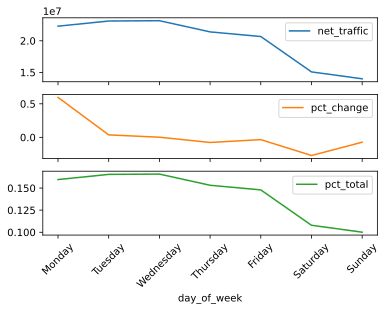

In [29]:
dayofweek_df.plot(subplots=True);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);

In [30]:
top_stations = df.groupby('station')[['net_traffic']].sum().sort_values(by='net_traffic', ascending=False).reset_index().copy()
top_stations['pct_total'] = top_stations['net_traffic'].apply(lambda x: x / top_stations.net_traffic.sum())
top_stations

,station,net_traffic,pct_total
0,34_st_penn_sta,4080330.0,0.029195
1,23_st,2572429.0,0.018406
2,times_sq_42_st,2461998.0,0.017615
3,34_st_herald_sq,2379430.0,0.017025
4,fulton_st,2243409.0,0.016051
...,...,...,...
373,beach_98_st,16866.0,0.000121
374,tompkinsville,12841.0,0.000092
375,beach_105_st,9230.0,0.000066
376,broad_channel,7482.0,0.000054


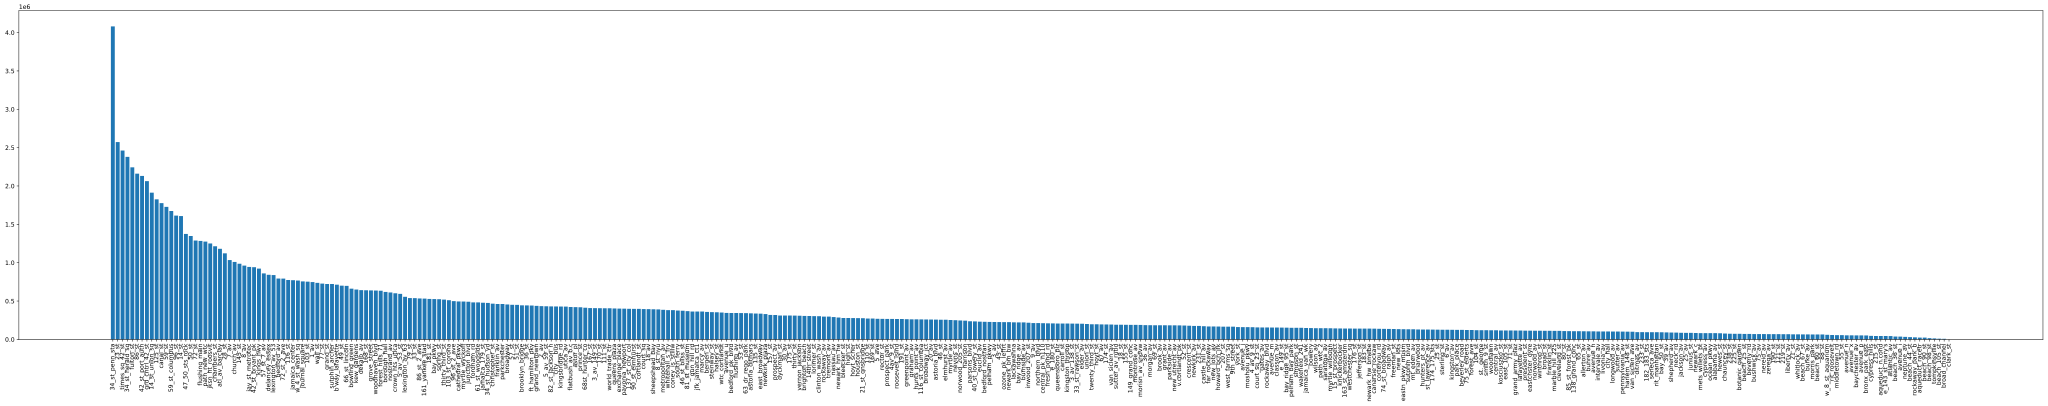

In [31]:
plt.figure(figsize=(60,10))
plt.bar(top_stations.station, top_stations.net_traffic);
plt.xticks(rotation=90);

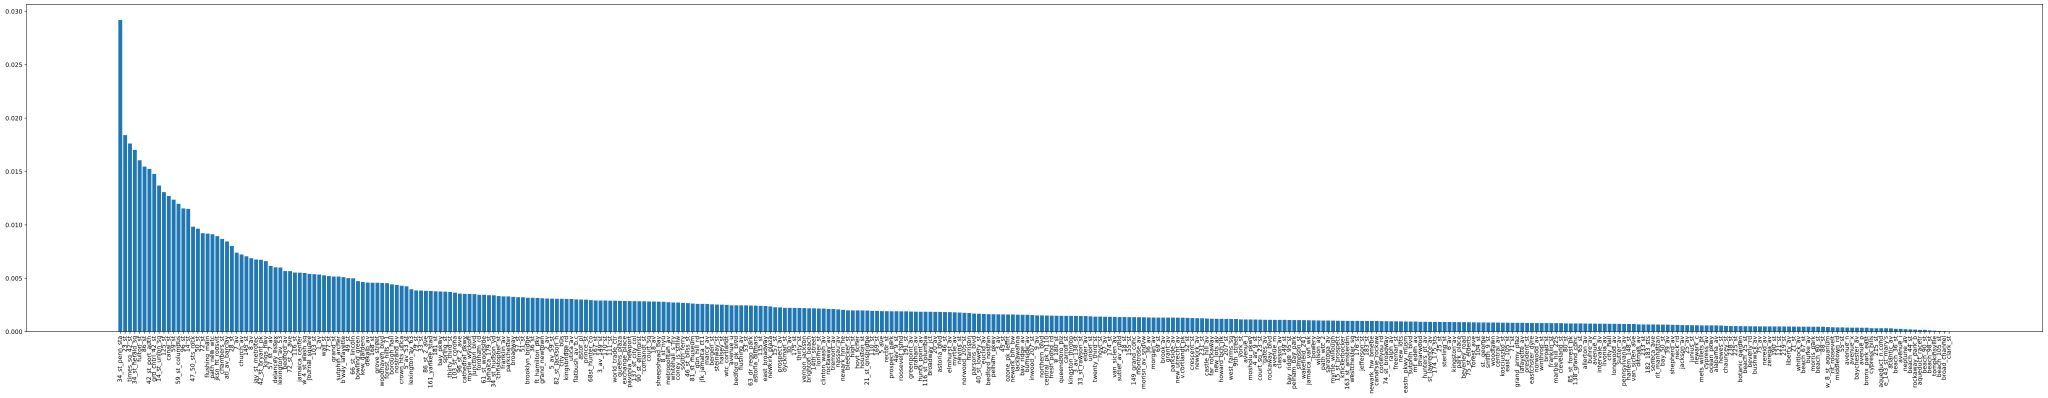

In [32]:
plt.figure(figsize=(60,10))
plt.bar(top_stations.station, top_stations.pct_total);
plt.xticks(rotation=90);

In [33]:
station_data = pd.read_csv('/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/body.csv')

In [34]:
station_data.stop_name = station_data.stop_name.str.replace(" - ","_")
station_data.stop_name = station_data.stop_name.str.replace(" ","_")
station_data.stop_name = station_data.stop_name.str.replace("(","")
station_data.stop_name = station_data.stop_name.str.replace(")","")
station_data.stop_name = station_data.stop_name.str.replace("/","_")
station_data.stop_name = station_data.stop_name.str.replace(".","")
station_data.stop_name = station_data.stop_name.str.replace("-","_")
station_data.stop_name = station_data.stop_name.str.lower()

/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be trea

In [36]:
station_data.stop_name.sort_values().tolist()

['103_st',
 '103_st',
 '103_st',
 '103_st_corona_plaza',
 '104_st',
 '104_st',
 '110_st',
 '111_st',
 '111_st',
 '111_st',
 '116_st',
 '116_st',
 '116_st',
 '116_st_columbia_university',
 '121_st',
 '125_st',
 '125_st',
 '125_st',
 '125_st',
 '135_st',
 '135_st',
 '137_st_city_college',
 '138_st_grand_concourse',
 '145_st',
 '145_st',
 '145_st',
 '145_st',
 '149_st_grand_concourse',
 '149_st_grand_concourse',
 '14_st',
 '14_st',
 '14_st',
 '14_st',
 '14_st_union_sq',
 '14_st_union_sq',
 '155_st',
 '155_st',
 '157_st',
 '15_st_prospect_park',
 '161_st_yankee_stadium',
 '161_st_yankee_stadium',
 '163_st_amsterdam_av',
 '167_st',
 '167_st',
 '168_st',
 '168_st_washington_hts',
 '169_st',
 '170_st',
 '170_st',
 '174_175_sts',
 '174_st',
 '175_st',
 '176_st',
 '181_st',
 '181_st',
 '182_183_sts',
 '183_st',
 '18_av',
 '18_av',
 '18_av',
 '18_st',
 '190_st',
 '191_st',
 '1_av',
 '207_st',
 '20_av',
 '20_av',
 '215_st',
 '219_st',
 '21_st',
 '21_st_queensbridge',
 '225_st',
 '231_st',
 '233_s

In [ ]:
top_station_df = pd.merge(top_stations, right=station_data, left_on='station', right_on='stop_name')
top_station_df.sort_values(by='pct_total', ascending=False)

In [ ]:
nta_map = gpd.read_file('/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/nynta2020.shp')
nta_map.to_crs(4326, inplace=True)
nta_map.crs

In [ ]:
nta_map.head()

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
nta_map.plot(ax=ax);

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
station_df.plot(ax=ax, markersize=20, color='blue', marker='o', label = 'Station')

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.plot(ax=ax);
station_df.plot(ax=ax, markersize=20, color='red', marker='o', label = 'Station');